In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./data/ums_viz.csv')
df_perf = pd.read_pickle('descriptions.pkl')
df_perf.columns.values[0] = 'perf_name'

df['perf_name'] = df['perf_name'].apply(lambda x: x.strip())
df_perf['perf_name'] = df_perf['perf_name'].apply(lambda x: x.strip())

df['per_seat'] = df['tck_amt']/df['num_seats']
df_group = df.groupby('perf_name')

# Add a whole bunch of new performance-level features

# mean ticket amount, number of seats, price per seat
df_tmp = df_group['tck_amt', 'num_seats', 'per_seat'].mean().reset_index()
df_tmp = df_tmp.rename(columns = {'tck_amt': 'mean_tck_amt', 'num_seats': 'mean_num_seats', 'per_seat': 'mean_per_seat'})

df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

# max ticket amount, number of seats, price per seat
df_tmp = df_group['tck_amt', 'num_seats', 'per_seat'].max().reset_index()
df_tmp = df_tmp.rename(columns = {'tck_amt': 'max_tck_amt', 'num_seats': 'max_num_seats', 'per_seat': 'max_per_seat'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

# total number of seats
df_tmp = df_group['num_seats'].count().reset_index()
df_tmp = df_tmp.rename(columns = {'num_seats': 'count_tck_amt'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

print df_perf

                perf_name                                        description  \
0     The Infernal Comedy  John Malkovich makes his UMS debut portraying ...   
1        Yuja Wang, piano  Chinese pianist Yuja Wang combines the spontan...   
2     London Philharmonic  The London Philharmonic returns for its first ...   
3        Hamburg Symphony  In 1971, French composer Olivier Messiaen was ...   
4    Chicago Symphony Orc  Wind players of the Chicago Symphony come toge...   
5    San Francisco Sympho  Michael Tilson Thomas and the San Francisco Sy...   
6      Pavel Haas Quartet  “The world’s most exciting string quartet? Wel...   
7        Ballet Preljocaj  Few audience members in attendance at Ballet P...   
8             Joshua Bell  Often referred to as a “poet of the violin,” J...   
9          Murray Perahia  In the more than 35 years he has been performi...   
10    Mariinsky Orchestra  The Mariinsky Orchestra and Valery Gergiev ret...   
11   Detroit Symphony Orc  A concert cre

In [4]:
# Extract bigram matrix

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

MIN_DF = 5

vect = CountVectorizer(ngram_range=(1, 1), stop_words=ENGLISH_STOP_WORDS, min_df=MIN_DF)
X = vect.fit_transform(df_perf.description.values)

print X.shape

(143, 446)


In [5]:
# Latent Dirichlet Allocation

from sklearn.decomposition import LatentDirichletAllocation

N_TOPICS = 5

lda = LatentDirichletAllocation(n_topics=N_TOPICS, max_iter=10)
y = lda.fit_transform(X)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

print_top_words(lda, vect.get_feature_names(), 20)

df_perf['topic'] = np.argmax(y, 1)

Topic #0:
music ums new american times concert york ballet company voice program audiences dance contemporary works composers century performed hall musical
Topic #1:
theatre national theater london michigan play broadcasts high presented definition partnership director award new winning time shakespeare people takes tour
Topic #2:
music performance best arbor ann new michigan musical ums jazz classical album like year traditions ensemble international dance art community
Topic #3:
performance dance ballet set ums office white small created astonishing dancing season action company work view guardian movement st world
Topic #4:
jazz lincoln center orchestra including band images rich concert big modern instrument performs symphony today work members broadcasts piece philharmonic



In [6]:
df_perf.head()

,perf_name,description,mean_tck_amt,mean_num_seats,mean_per_seat,max_tck_amt,max_num_seats,max_per_seat,count_tck_amt,topic
0,The Infernal Comedy,John Malkovich makes his UMS debut portraying ...,72.092196,1.997354,37.194444,595.0,14,75.0,1512,0
1,"Yuja Wang, piano",Chinese pianist Yuja Wang combines the spontan...,63.171001,2.003096,32.884830,460.0,23,56.0,969,2
2,London Philharmonic,The London Philharmonic returns for its first ...,77.771242,1.937255,40.968301,1000.0,50,80.0,1530,0
3,Hamburg Symphony,"In 1971, French composer Olivier Messiaen was ...",62.176976,1.838933,34.027619,487.5,17,65.0,1012,4
4,Chicago Symphony Orc,Wind players of the Chicago Symphony come toge...,110.584576,1.914630,56.604253,14960.0,187,120.0,3151,2


## Plots

### Pair grid plot

In [17]:
import seaborn as sns

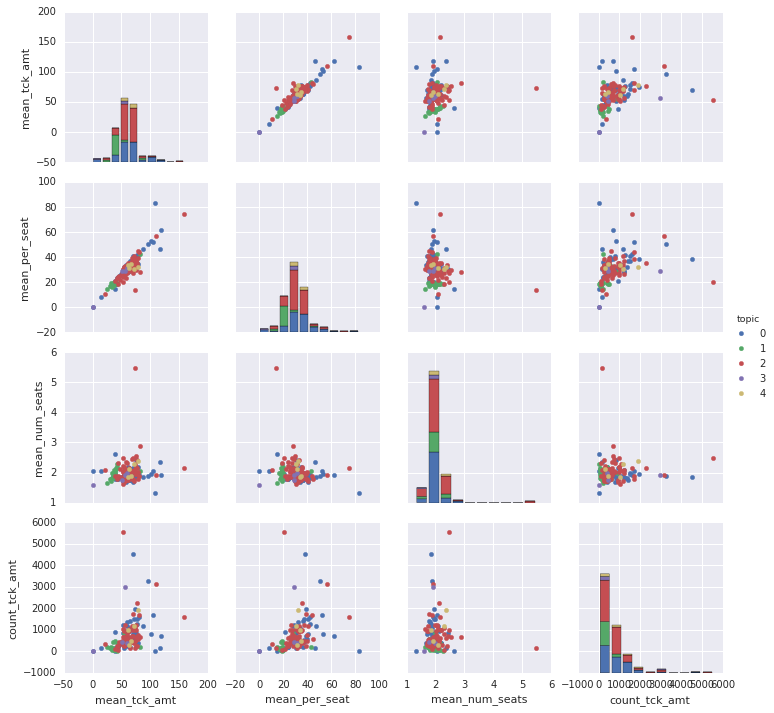

In [22]:
variables = ['mean_tck_amt', 'mean_per_seat', 'mean_num_seats', 'count_tck_amt']
g = sns.PairGrid(df_perf, vars=variables, hue='topic')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g.add_legend()

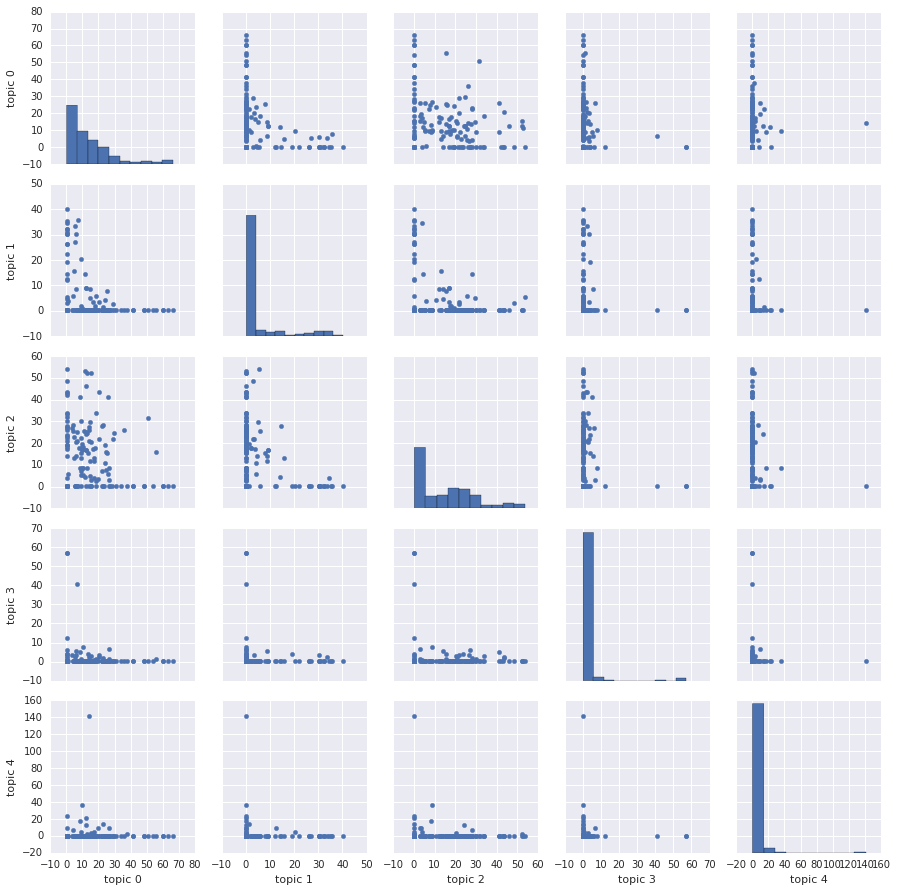

In [29]:
# Pair grid plot in topic space

topic_scores = pd.DataFrame(y, columns=['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4'])
g = sns.PairGrid(topic_scores)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)